## Problem Statement

***NOTE:*** The following code is an extention to the [CF_GA.ipynb](./CF_GA.ipynb) notebook. It incorporates a local search component into the standard genetic algorithm framework, transforming it into a ***Memetic Algorithm (MA)***. This modification is aimed at evaluating whether the inclusion of a local search can enhance the algorithm’s performance. (The [CF_GA.ipynb](./CF_GA.ipynb) file contains thorough explanations of the GA functions and operators. In this document, we narrow our focus to the components that are unique to the MA and we will provide detailed explanations of the MA-specific functions.)

Memetic Algorithms (MAs), also known as hybrid genetic algorithms, are an advanced form of a GAs that combines the global search perspective of genetic algorithms with local refinement techniques. The local search aspect, which is the hallmark of memetic algorithms, intensifies the search in the neighborhood of promising solutions found by the evolutionary process, aiming to enhance precision and convergence speed.

**Local Search** (Improvement Operator) is the distinguishing feature of MAs. After the traditional GA operators (selection, crossover, mutation) generate new candidates, the local search is applied to these individuals.


In [91]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [122]:
pop_size = 200
x = []
y = []

instuc = []
with open('./CurveFitting-Tests/CurveFitting_test2.txt', 'r') as file:
    # Iterate through each line in the file
    for line in file:
        # Split the line into a list of numbers (as strings)
        parts = line.split()

        if len(parts) == 2:
            x.append(float(parts[0]))
            y.append(float(parts[1]))
        else:
            instuc.append(int(parts[0]))

n = instuc[0] + 1
coef_min = x[0]
coef_max = y[0]
x = x[1:]
y = y[1:]

wide_range_y = False
if max(y) > 1e20 or min(y) < -1e20:
    wide_range_y = True

## Memetic Algorithm Operators

### Chromosome

All functions are priorly explained in GA implementation, the only function that actually makes difference between GA and MA is `gradientDescent()` method. Gradient descent is an optimization algorithm used to minimize a function by iteratively moving towards the minimum value. In the context of memetic algorithms for solving polynomial curve fitting problems, gradient descent can be incorporated as a local search technique to refine solutions.

![Grad](./gd.png)

Gradient descent iteratively adjusts the parameters (coefficients of the polynomial in our case) in order to minimize a cost function (e.g., Mean Absolute Error). The essential idea is:

- Initialize the parameters of the polynomial randomly or based on some heuristic.
- Evaluate the Gradient: Calculate how much a slight change in each parameter would increase or decrease the cost function. This is done by computing the gradient of the cost function with respect to each parameter.
- Update the Parameters: Adjust the parameters in the opposite direction of the gradient to reduce the cost. The size of the step for each parameter is determined by the learning rate.
Iterate: Repeat steps 2 and 3 until the decrease in the cost function is below a threshold or a set number of iterations have been completed.

Given a set of data points $(x_i, y_i)$, where $(x_i)$ are the inputs and $y_i$ are the observed outputs, and a polynomial function $f(x, \vec{a}) = a_0 + a_1x + a_2x^2 + \ldots + a_nx^n$ with coefficients $\vec{a} = (a_0, a_1, \ldots, a_n)$, the MAE can be defined as:

$$
MAE(\vec{a}) = \frac{1}{N} \sum_{i=1}^{N} |y_i - f(x_i, \vec{a})|
$$

where $N$ is the number of data points.

To use gradient descent for minimizing the MAE, you would update the coefficients $\vec{a}$ iteratively following the negative gradient of the MAE with respect to each coefficient. However, deriving the gradient of MAE is not as straightforward as for the Mean Squared Error (MSE), due to the absolute value, which makes the function non-differentiable at zero. Therefore, sub-gradient methods are often employed.

During each iteration of gradient descent, the update rule for each coefficient $a_j$ could be approximated by considering the sign of the error term:

$$
a_j := a_j - \alpha \cdot \left( \frac{1}{N} \sum_{i=1}^{N} \text{sgn}(y_i - f(x_i, \vec{a})) \cdot \frac{\partial}{\partial a_j}f(x_i, \vec{a}) \right)
$$

where:
- $\alpha $ is the learning rate, a positive scalar determining the step size.
- $ \text{sgn}() $ is the sign function, which outputs -1 if the argument is negative, 0 if the argument is zero, and 1 if the argument is positive.
- $\frac{\partial}{\partial a_j}f(x_i, \vec{a}) $ is the partial derivative of the polynomial function $f(x, \vec{a})$ with respect to the coefficient $a_j$, which is essentially the term $x_i^j$.

The above steps are essentially what the code below illustrates:

- `X_poly = np.vander(x, N=len(self.chr))` $\rightarrow$ Calculation for $x_i^j$ for $0<i<\text{len}(x)$ and $0<j<\text{order}$.

- `judge = np.sign(y_pred - y)` $\rightarrow$ Ctores the result of $\text{sgn}(y_i - f(x_i, \vec{a}))$

- `delta = (alpha/m) * np.dot(judge, X_poly)` $\rightarrow$ Represents the ***subgradient*** of the cost function. It is multiplied by the learning rate ($\alpha$) and then subtracted from our current solution (chromosome), to iteratively improve upon it.



In [93]:
class Chromosome:
    global x, y, n, wide_range_y
    def __init__(self, chr):
        self.chr = chr
        self.fitness, self.chr_y = self.fitFunc(self.chr)

    def fitFunc(self, chr):
        self.chr_y = np.polyval(chr, x)
        self.fitness = np.sum([abs(y1 - y2) for (y1, y2) in zip(self.chr_y, y)]) * (1/len(y))
        return self.fitness, self.chr_y
    
    def mutateComp(self, m1):
        self.chr[m1] = coef_max + coef_min - self.chr[m1]
        self.fitness, self.chr_y = self.fitFunc(self.chr)
        return
    
    def mutateSwap(self, m1, m2):
        tmp = self.chr[m1]
        self.chr[m1] = self.chr[m2]
        self.chr[m2] = tmp
        self.fitness, self.chr_y = self.fitFunc(self.chr)
        return
    
    def gradientDescent(self, num_iters=1000, stop_th=1, alpha=1e-20):
        m = len(y)
        prev_cost = self.fitness
        #print(len(self.chr))
        save = prev_cost

        for _ in range(num_iters):
            y_pred = np.polyval(self.chr, x)
            judge = np.sign(y_pred - y)
            X_poly = np.vander(x, N=len(self.chr))  
            delta = (alpha/m) * np.dot(judge, X_poly)
            self.chr -= alpha * delta
            self.chr = list(self.chr)
            cur_cost = self.fitFunc(self.chr)[0]
            prev_cost = cur_cost 
            #print(len(self.chr))
            if abs(prev_cost - cur_cost)<=stop_th:
                break
        return


### Initialization

In [94]:
def generatePop():
    pop = []
    for _ in range(pop_size):
        c = [random.uniform(coef_min, coef_max) for _ in range(n)]
        pop.append(Chromosome(c))
    #print(f'Population of size {len(pop)} generated.')
    return pop

### Selection

In [95]:
def tournSelect(pop, t_round=int(pop_size/2), elit=int(pop_size/25)):
    parents = []
    pop.sort(key=lambda chr: chr.fitness)

    #elitism
    #parents = pop[:1]
    #random.shuffle(pop)
    #print('parents', len(parents), parents[0].fitness)

    selected = []
    for _ in range(t_round):
        selected = random.sample(pop, 2)
        selected = sorted(selected, key=lambda chr: chr.fitness)
        #print('selected', len(selected), selected[0].fitness, selected[1].fitness)
        parents.append(selected[0])
    random.shuffle(parents)
    #print(f'Selection complete! Parent pool size = {len(parents)}.')
    return parents

def truncSelect(pop):
    parents = []
    pop.sort(key=lambda chr: chr.fitness)
    parents = pop[:int(pop_size/2)]
    random.shuffle(parents)
    #print(f'Selection complete! Parent pool size = {len(parents)}.')
    return parents

### Crossover

In [96]:
def crossover2p(p_pool, cross_rate=0.9):
    offspring = []
    for _ in range(len(p_pool)):
        p1, p2 = random.sample(p_pool, 2)
        if random.random() <= cross_rate:
            co1 = random.randint(0, len(p1.chr) - 1)
            co2 = random.randint(0, len(p1.chr) - 1)
            c1 = p1.chr[:co1] + p2.chr[co1:co2] + p1.chr[co2:]
            c2 = p2.chr[:co1] + p1.chr[co1:co2] + p2.chr[co2:]
            offspring.append(Chromosome(c1))
            offspring.append(Chromosome(c2))
        else:
            offspring.append(p1)
            offspring.append(p2)

    #print(f'Crossover complete! offsprint pool size = {len(offspring)}.')
    return offspring

def crossover1p(p_pool, cross_rate=0.9):
    offspring = []
    for _ in range(len(p_pool)):
        p1, p2 = random.sample(p_pool, 2)
        if random.random() <= cross_rate:
            p1, p2 = random.sample(p_pool, 2)
            co1 = random.randint(0, len(p1.chr) - 1)
            c1 = p1.chr[:co1] + p2.chr[co1:]
            c2 = p2.chr[:co1] + p1.chr[co1:]
            offspring.append(Chromosome(c1))
            offspring.append(Chromosome(c2))
        else:
            offspring.append(p1)
            offspring.append(p2)

    #print(f'Crossover complete! offspring pool size = {len(offspring)}.')
    return offspring

### Mutation

In [97]:
def mutationSwap(offs, mut_point = 3, mut_rate = 0.2):
    for i in range(len(offs)):
        if random.random() <= mut_rate:
            for _ in range(mut_point):
                m1 = random.randint(0, len(offs[i].chr) - 1)
                m2 = random.randint(0, len(offs[i].chr) - 1)
                while m1==m2:
                    m2 = random.randint(0, len(offs[i].chr) - 1)
                offs[i].mutateSwap(m1, m2)
    
    #print(f'Mutation complete! offspring pool size = {len(offs)}.')
    return offs

def mutationComp(offs, mut_point = 3, mut_rate = 0.2):
    for i in range(len(offs)):
        if random.random() <= mut_rate:
            for _ in range(mut_point):
                m1 = random.randint(0, len(offs[i].chr) - 1)
                offs[i].mutateComp(m1)
    
    #print(f'Mutation complete! offspring pool size = {len(offs)}.')
    return offs

### Replacement

In [98]:
def replacePop(p, o, elit=int(pop_size/20)):
    new_gen = []
    p.sort(key=lambda chr: chr.fitness)
    o.sort(key=lambda chr: chr.fitness)
    #elitisim applied
    new_gen = p[:2] + o[:int(pop_size)-2]
    random.shuffle(new_gen)
    
    #print(f'New population of size {len(new_gen)} generated')
    return new_gen

### Local Search (Gradient Descent)

Local search in MAs is a refinement process that enhances the solution quality within a population-based evolutionary algorithm framework. The local search component is applied to chromosomes, or ***memes***, to explore their immediate neighborhood in the solution space. This is typically an iterative process, where each iteration seeks to make a small, incremental change to the solution with the intent of finding a local optimum.

The main idea behind integrating local search into GAs is to balance between the exploration of the solution space (through genetic operators like crossover and mutation) and the exploitation of the best-found solutions (through local search). This synergy enables memetic algorithms to avoid premature convergence to suboptimal regions—which can be a common issue with traditional GAs—and to fine-tune solutions to a higher degree of accuracy.

Different local search strategies can be employed within MAs, such as hill climbing, simulated annealing, or the use of domain-specific heuristics. The choice of local search method depends on the characteristics of the specific problem being solved. In our case we have applied gradient descent to only the fittest individuals (controlled by parameter `num_o`) to maintain a balance between search diversification and intensification.

Before integrating the local search method, gradient descent, into our genetic algorithm, I conducted preliminary tests to ensure its effectiveness on our dataset and its ability to improve chromosome fitness. These tests were carried out in the [GradDesTest.ipynb](./GradDesTest.ipynb) notebook, where I also fine-tuned the learning rate parameter crucial for the algorithm’s optimal performance.

In [99]:
def localSearch(offs, num_o=10, lr=1e-10):
    offs.sort(key=lambda chr: chr.fitness)
    for i in range(num_o):
        offs[i].gradientDescent(stop_th=1, alpha=lr)
    return offs

## Results

In [104]:
def mainGA(it_no=1000, mr=0.2, cr=0.8, lr=1e-10):
    iterations_no = it_no
    mut_rate = mr
    cross_rate = cr
    
    # for plotting and visualization
    fitness_recorder = []
    tm = []
    last_5_fitness = []
    
    it = 0
    # initialize popylation
    pop = generatePop()
    while (it <= iterations_no):
        parents = tournSelect(pop)
        offspring = crossover1p(parents, cross_rate)
        offspring = mutationSwap(offspring, 3, mut_rate)
        offspring = localSearch(offs=offspring, num_o=2, lr=lr)
        new_gen = replacePop(parents, offspring)

        new_gen.sort(key=lambda chr: chr.fitness)

        if it % 50 == 0:
            print(f'Generation: {it}, Best Fitness Value: {new_gen[0].fitness}')
            fitness_recorder.append(new_gen[0].fitness)
            tm.append(it)
            last_5_fitness.append(new_gen[0].fitness)
            
            if len(last_5_fitness) > 5:
                last_5_fitness.pop(0)

            points = list(zip(x, new_gen[0].chr_y))
            points = sorted(points, key=lambda fx: fx[0])
            my_x, my_y = zip(*points)
            plt.plot(my_x, my_y, color='red')
            plt.scatter(x, y)
            plt.show()

        # Ending criteria: in the last 5 iterations no noticable change in fitness is seen
        if new_gen[0].fitness == 0:
            print("SUCCESS")
            break
        if len(last_5_fitness) == 5 and (max(last_5_fitness) - min(last_5_fitness)) < 4e-6*n:
            print("Stopping Criterion Met.")
            break

        pop = new_gen
        it += 1 
    return new_gen[0].chr, fitness_recorder, tm

### Test Case 1

- The mutation and crossover rates did not need any adjustments so the default settings for the GA were maintained.
- The learning rate parameter was adjusted in [GradDesTest.ipynb](./GradDesTest.ipynb) before execution.

- After 300 iterations in both the GA and MA, the best fitness result for GA was 2206567919.8188305, while for MA it was 1864831858.1401477. Therefore, we can conclude that MA demonstrated a 15% improvement in performance compared to GA in test case 1.

Generation: 0, Best Fitness Value: 15048306189.396376


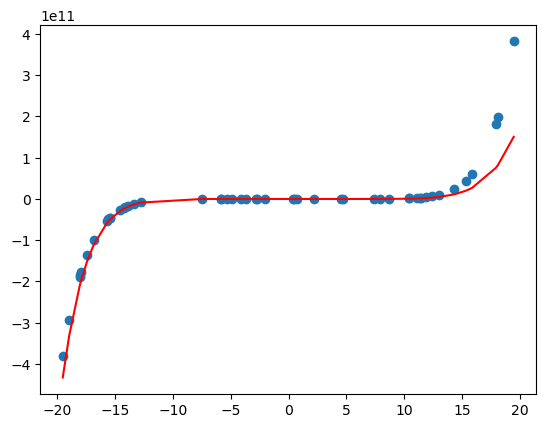

Generation: 50, Best Fitness Value: 1888128727.7008877


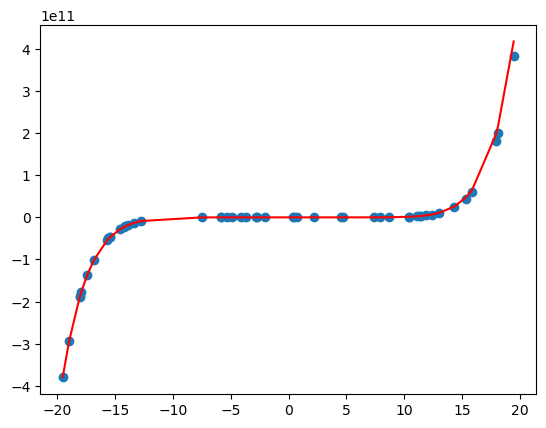

Generation: 100, Best Fitness Value: 1884020016.0497203


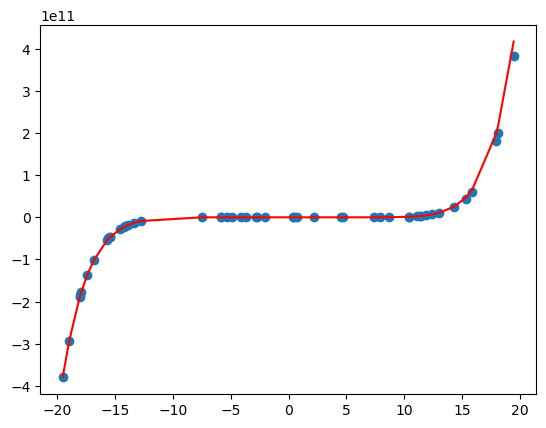

Generation: 150, Best Fitness Value: 1879667840.5576344


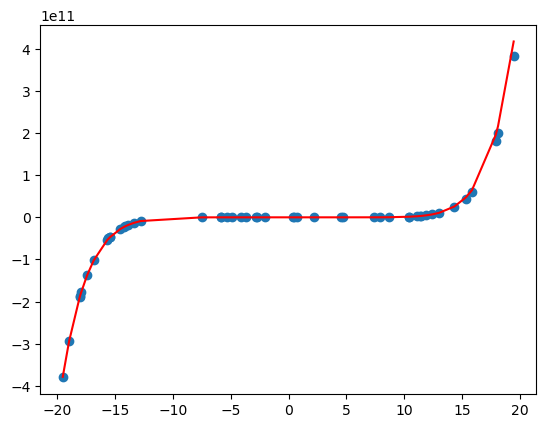

Generation: 200, Best Fitness Value: 1874443744.3908882


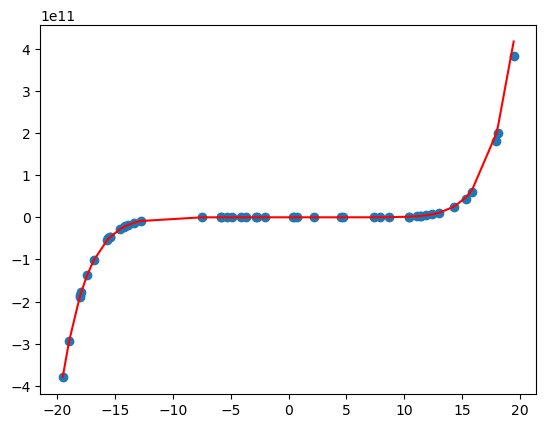

Generation: 250, Best Fitness Value: 1869066851.9002557


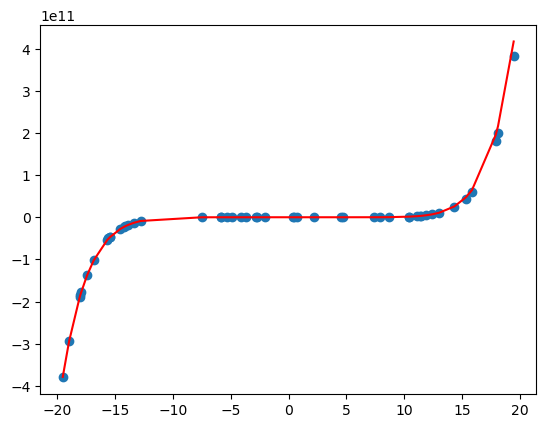

Generation: 300, Best Fitness Value: 1864831858.1401477


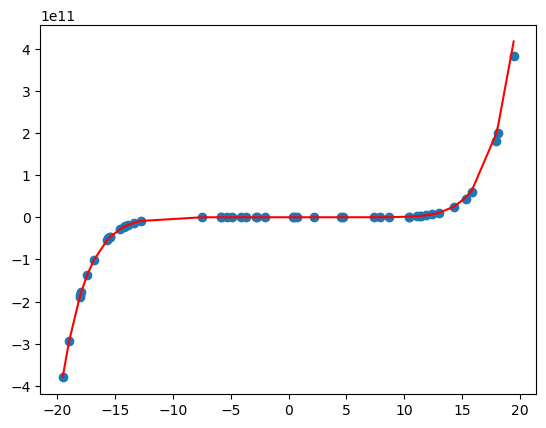

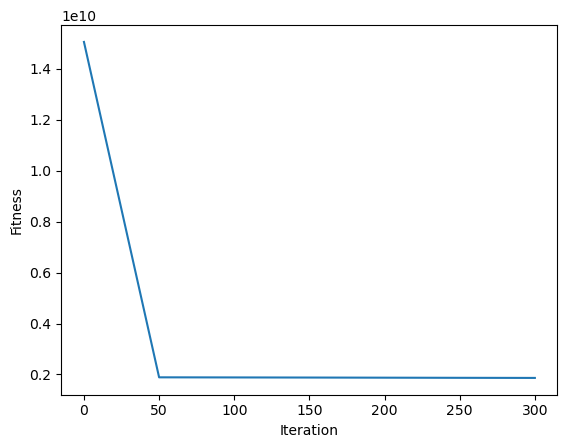

In [110]:
res, recorder, tm = mainGA(300, 0.5, 0.8, 1e-8)
plt.plot(tm, recorder)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()

### Test Case 2

- The data displayed in the graphs indicate that, although the algorithm initially generates promising solutions, these are not maintained in subsequent iterations. To refine the algorithm’s ability to consistently progress toward an optimal or near-optimal solution, adjustments are needed. Specifically, decreasing the mutation rate will help preserve the integrity of effective genetic combinations previously discovered. Therefore, the mutation rate has been lowered, and simultaneously, the crossover rate has been heightened. This adjustment aims to minimize random variations and focus the algorithm on improving the existing solutions rather than extensively searching for new ones.

- The learning rate parameter was adjusted in [GradDesTest.ipynb](./GradDesTest.ipynb) before execution.

- After 300 iterations in both the GA and MA, the best fitness result for GA was 13495832991.723494, while for MA it was 8108555800.654491. Therefore, we can conclude that MA demonstrated a 40% improvement in performance compared to GA in test case 2.

Generation: 0, Best Fitness Value: 501881796889.5616


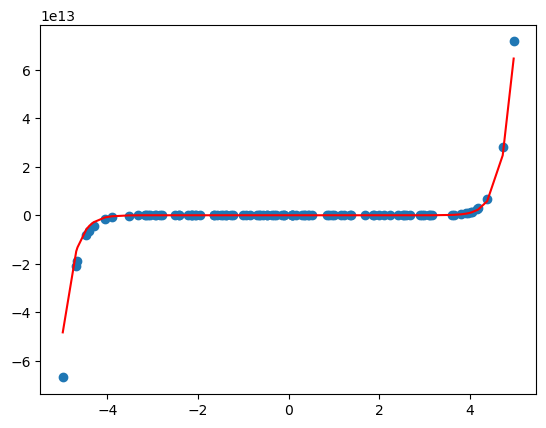

Generation: 50, Best Fitness Value: 8211880654.852068


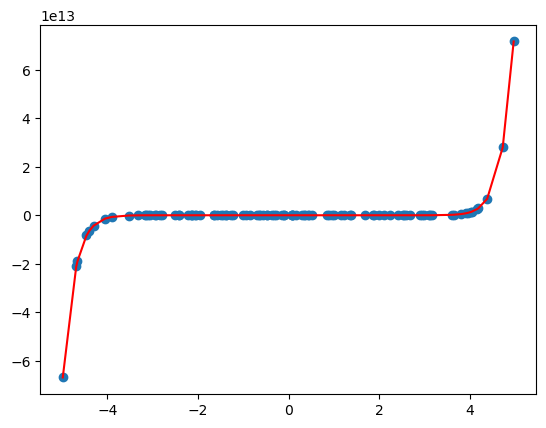

Generation: 100, Best Fitness Value: 8110836437.748677


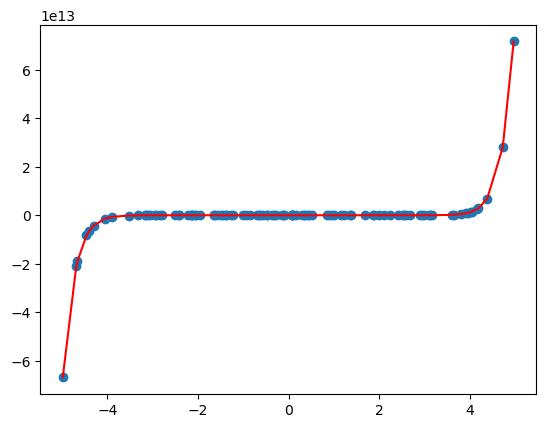

Generation: 150, Best Fitness Value: 8108736505.601106


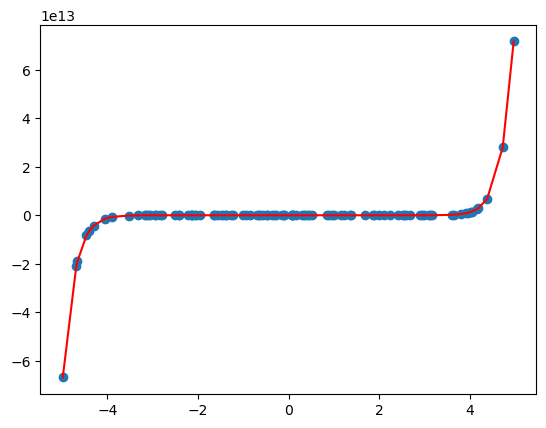

Generation: 200, Best Fitness Value: 8108544047.439423


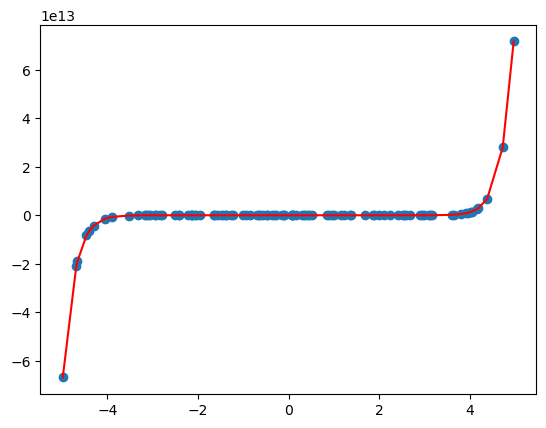

Generation: 250, Best Fitness Value: 8108561477.054878


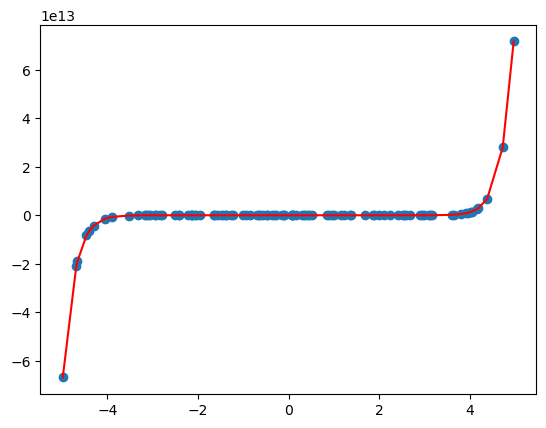

Generation: 300, Best Fitness Value: 8108555800.654491


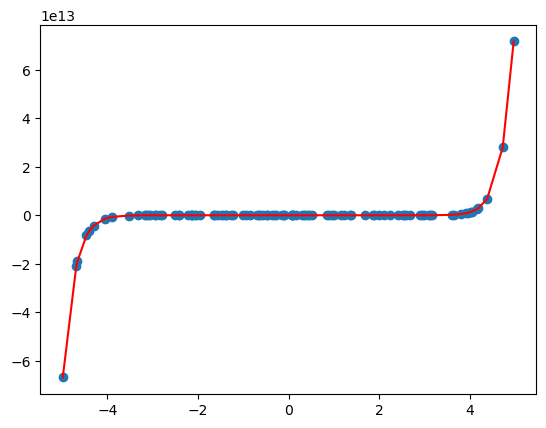

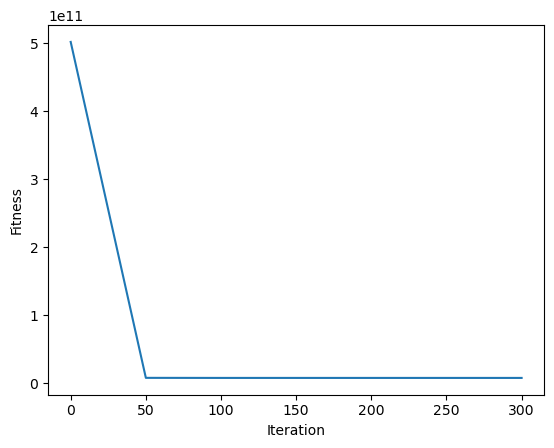

In [130]:
res, recorder, tm = mainGA(it_no=300, mr=0.4, cr=0.9, lr=1e-8)
plt.plot(tm, recorder)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()

### Test Case 3


- The plots below reveal that the algorithm was repeatedly converging on local optima, with no further improvements over many iterations. To counteract this, the mutation rate was increased, allowing for a greater chance to bypass these suboptimal zones. This change introduces more variability, enabling the algorithm to explore different areas of the solution space and potentially discover more optimal solutions.

- The learning rate parameter was adjusted in [GradDesTest.ipynb](./GradDesTest.ipynb) before execution.

- After 300 iterations in both the GA and MA, the best fitness result for GA was 4.1024832847333204e+29, while for MA it was 2.757932354402526e+29. Therefore, we can conclude that MA demonstrated a 33% improvement in performance compared to GA in test case 2.


Generation: 0, Best Fitness Value: 8.027721806551775e+30


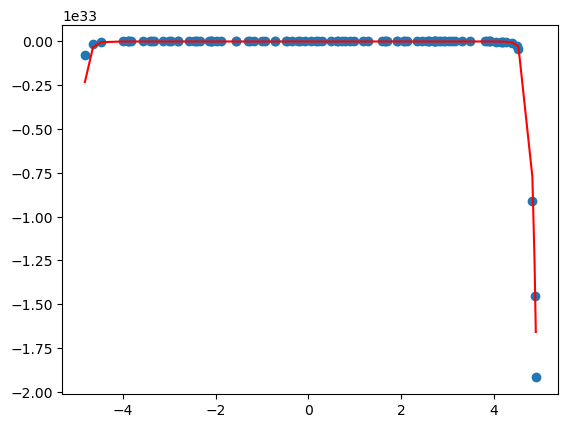

Generation: 50, Best Fitness Value: 5.275597577632993e+29


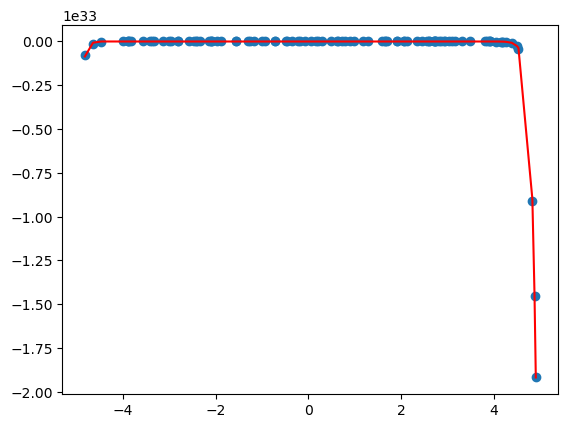

Generation: 100, Best Fitness Value: 4.976331514572438e+29


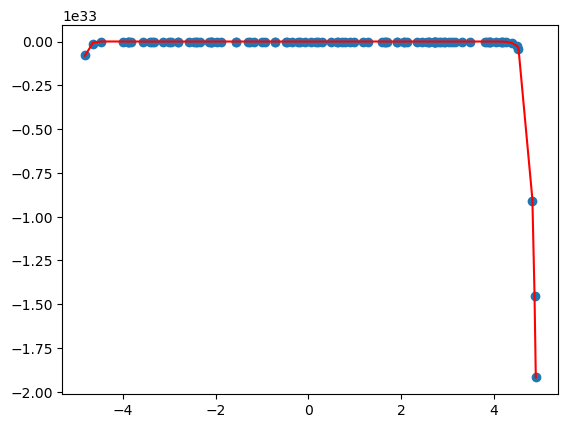

Generation: 150, Best Fitness Value: 4.471112216254107e+29


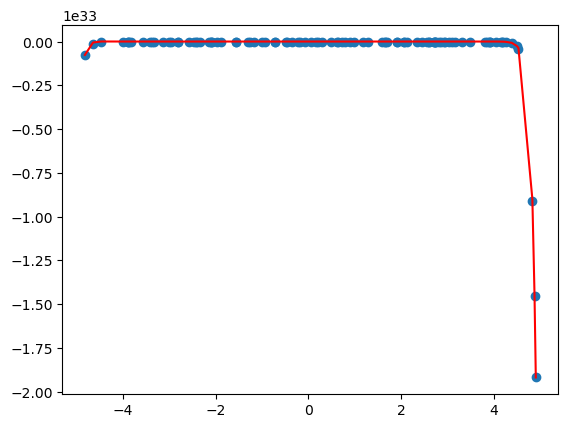

Generation: 200, Best Fitness Value: 4.2243202601338826e+29


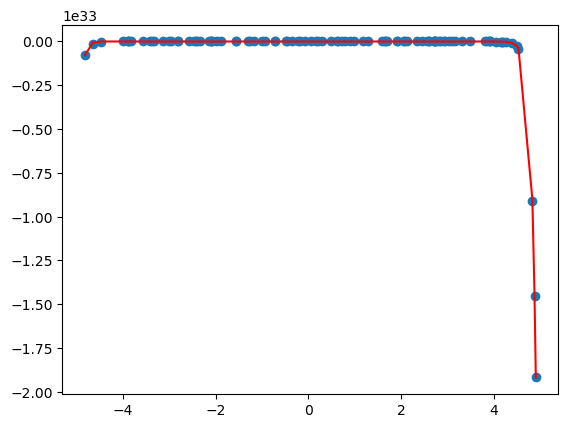

Generation: 250, Best Fitness Value: 2.8081854672043497e+29


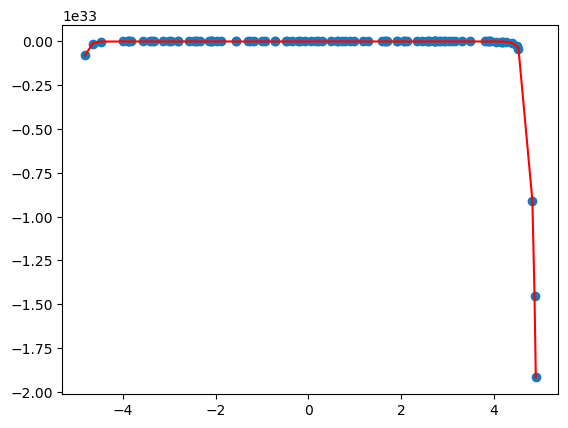

Generation: 300, Best Fitness Value: 2.757932354402526e+29


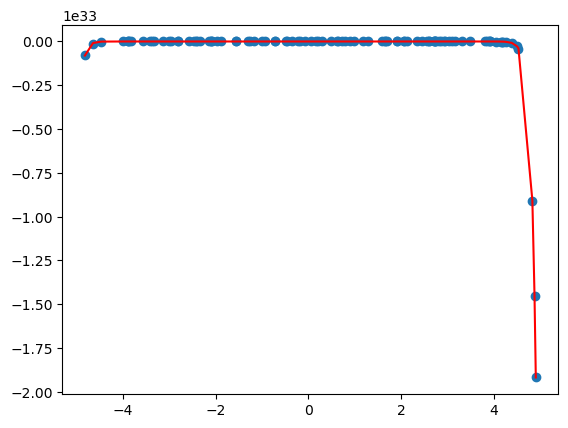

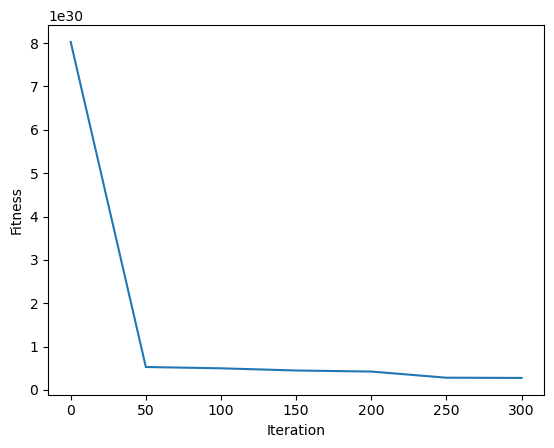

In [115]:
res, recorder, tm = mainGA(300, 0.7, 0.9, 1e-18)
plt.plot(tm, recorder)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()

### Test Case 4

- The mutation and crossover rates did not need any adjustments so the default settings for the GA were maintained.
- The learning rate parameter was adjusted in [GradDesTest.ipynb](./GradDesTest.ipynb) before execution.

- After 300 iterations in both the GA and MA, the best fitness result for GA was 65205191.778168686, while for MA it was 45867669.311644375. Therefore, we can conclude that MA demonstrated a 30% improvement in performance compared to GA in test case 1.

Generation: 0, Best Fitness Value: 259643915.54907414


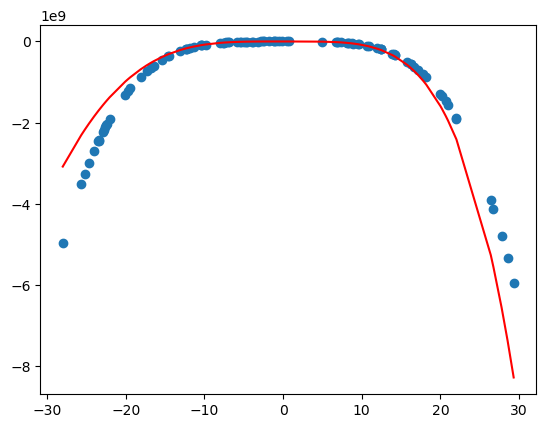

Generation: 50, Best Fitness Value: 46939863.23182009


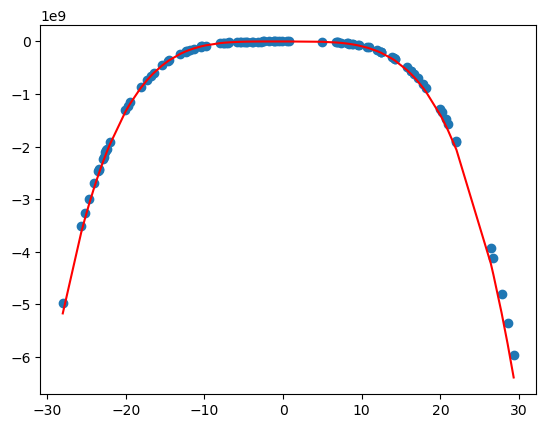

Generation: 100, Best Fitness Value: 46678846.20969084


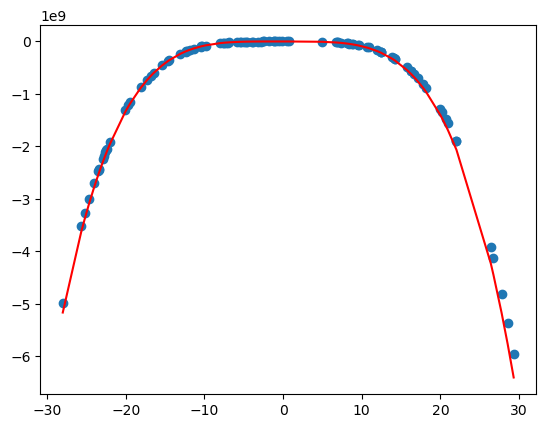

Generation: 150, Best Fitness Value: 46560200.51006134


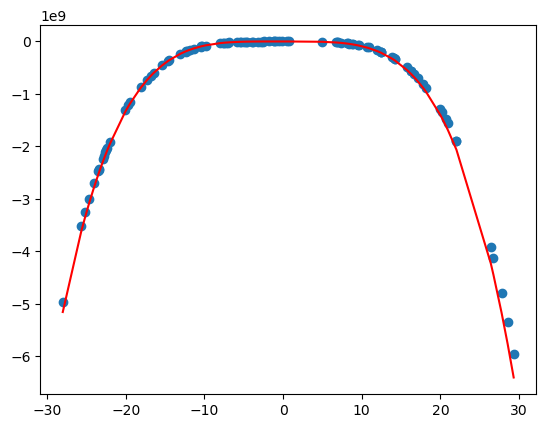

Generation: 200, Best Fitness Value: 46471642.688769504


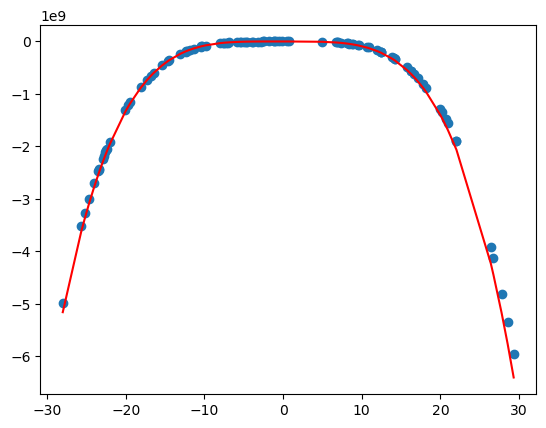

Generation: 250, Best Fitness Value: 46136179.40460258


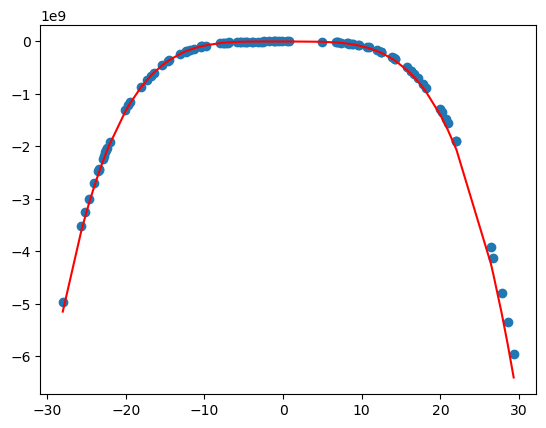

Generation: 300, Best Fitness Value: 45867669.311644375


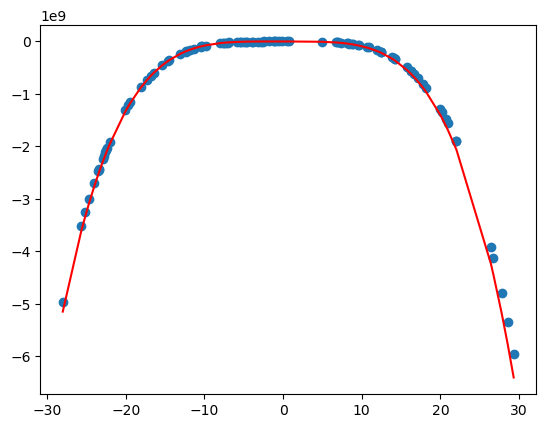

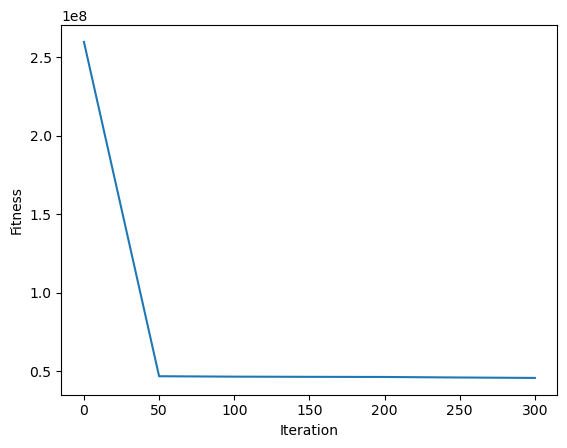

In [121]:
res, recorder, tm = mainGA(it_no=300, mr=0.5, cr=0.9, lr=1e-3)
plt.plot(tm, recorder)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()